<h1>Roomba Coverage</h1> 

A Roomba is a robotic vacuum cleaner that automatically moves
around a room or a house to clean the floor. Model the floor of a house on an integer grid
(so discrete rather than continuous) and mark cells as open floor or an obstacle (wall or
furniture).

Search for information on the Roomba and compare the effectiveness of different
movement strategies or combinations of strategies — for example, "random bounce" and
"wall following". The goal is to clean the whole floor as evenly as possible — if it misses
part of the floor that part will not get cleaned, and if it visits some floor region very often, it is
wasting time and battery power that it could be using to clean another part of the floor.

Use your simulation to evaluate different movement strategies and their effectiveness at
covering floor areas with obstacles on them.

In [5]:
#import libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
sns.set()
%matplotlib inline

In [162]:
#Roomba Simulation base class
class RoombaSim:

    def __init__(self, size=5, obstacle_density=0.1, strat = 'random_bounce', demo = False):
        '''
        Create a new roomba simulation object.

        Inputs:

            size (int) The grid will have dimensions of size x size. 
                Default: 5.

            obstacle_density (float) The fraction of cells that have an obstacle on them.
                Default: 0.3.
                
            strat (str) The strategy to be used for floor cleaning.
                Default: random_bounce.
              
            demo (bool) If True, will display the floor grid with walls, obstacles, and roomba.
                Default: False
        '''
        self.demo = demo
        self.size = size + 2 # add 2 to account for the wall-occupied space that cannot be accessed
        self.obstacle_density = obstacle_density
        self.strat = strat

        # Track the time steps.
        self.time_step = 1
        
        #set state by creating the floor
        self.state = self.create_floor()
        
        #get obstacle locations
        self.obstacle_loc = set([tuple(i) for i in np.array(np.where(self.state == 1)).T])
        
        #place roomba on floor
        self.roomba_loc = self.get_start_loc(self.state)
        self.state[self.roomba_loc[0], self.roomba_loc[1]] = 0
        
        #set previous location attribute
        self.prev_loc = self.roomba_loc
        self.prev_loc_set = set([self.prev_loc])
        
        #set metrics
        self.ratio_cleaned = 0
        self.cleaning_rate = 0
        
        #record when floor configuration traps roomba with obstacles
        self.roomba_trapped = False
        
    def create_floor(self):
        '''
        Initializes floor according to grid size and obstacle density.
        Walls are represented as obstacle as well, and occupy the outermost border 
        of the floor grid, e.g. first and last row, first and last column.
        
        Outputs:
            state (arr) numpy array of dimensions size x size 
                        representing the floor grid.
        '''
            
        #number of obstacles to place
        obstacle_count = int(self.obstacle_density * self.size * self.size)

        #initialize empty array for storing tuples of row, col values
        random_indices = np.zeros(obstacle_count, dtype=object)

        #assign obstacle_count number of random row, col values
        for i in range(obstacle_count):
            #randomly draw row, col values from range of (1, size - 1) to avoid selecting wall locations
            indices = np.random.choice(range(1, self.size - 1), size=2) 
            random_indices[i] = indices[0], indices[1]
        
        # -1 means empty cell
        state = -np.ones((self.size,self.size), dtype=int) 
        
        #place obstacles on the floor
        for i in random_indices: 
            state[i[0],i[1]] = 1 #1 means obstacle
            
        #create wall
        state[0], state[-1], state[:,0], state[:,-1] = 1, 1, 1, 1
    
        return state
    
    def get_start_loc(self, state):
        '''
        Get roomba's starting location by choosing randomly from any empty space on the floor grid.
        '''
        empty_cells = np.array(np.where(state == -1)).T
        start_loc = empty_cells[np.random.choice(len(empty_cells))]

        return tuple(start_loc)
    
    
    def choose_pos(self):
        '''
        Choose the roomba's next position based on the floor-cleaning strategy.
        
        Output:
            new_pos (tuple) A tuple in the form of (row, col) with the roomba's new coordinates.
        '''
        #roomba's neighborhood
        neighborhood = {
                'top': (self.roomba_loc[0] - 1, self.roomba_loc[1]),
                'top-right': (self.roomba_loc[0] - 1, self.roomba_loc[1] + 1),
                'top-left': (self.roomba_loc[0] - 1 , self.roomba_loc[1] - 1),
                'bottom': (self.roomba_loc[0] + 1, self.roomba_loc[1]),
                'bottom-right': (self.roomba_loc[0] + 1, self.roomba_loc[1] + 1),
                'bottom-left': (self.roomba_loc[0] + 1, self.roomba_loc[1] - 1),
                'left': (self.roomba_loc[0], self.roomba_loc[1] - 1),
                'right': (self.roomba_loc[0], self.roomba_loc[1] + 1)
            } 
     
        #default free positions = roomba's neighborhood - obstacles
        free_pos = set(neighborhood.values()) - self.obstacle_loc
        #print(f"Possible next moves: {free_pos}")
        
        #if no available positions, means that roomba was trapped by obstacles
        if len(free_pos) == 0: 
            #record that roomba was trapped
            self.roomba_trapped = True
            #just set to own position to avoid error
            free_pos = self.roomba_loc 
            
        if self.strat == 'one_step_memory':
            #description
            if len(free_pos - {self.prev_loc}) >= 1:
                free_pos -= {self.prev_loc}
                
        elif self.strat == 'multi_step_memory':
            #description
            if len(free_pos - self.prev_loc_set) >= 1:
                free_pos -= self.prev_loc_set
                
        #default random bounce strategy
        new_pos = list(free_pos)[np.random.choice(len(free_pos))] 
                        
        return new_pos
    
    def move_roomba(self, new_pos):
        '''
        Move roomba to the given next position.
        '''
        #create a copy of the old state
        new_state = -np.ones((self.size,self.size), dtype=int) 
        for i in self.obstacle_loc: new_state[i] = 1
        
        #make the old roomba position empty again
        new_state[self.roomba_loc] = -1

        #move roomba to the next pos
        new_state[new_pos] = 0

        return new_state
    
    def get_ratio_cleaned(self):
        '''
        Returns the proportion of floor tiles cleaned at current time-step.
        Tiles occupied by obstacles are not included in the calculation.
        '''
        obstacle_count = int(self.obstacle_density * self.size * self.size)
        open_floor = (self.size - 2)**2 - obstacle_count #use self.size-2 so that walls are not counted
        tiles_cleaned = len(self.prev_loc_set)
        ratio = tiles_cleaned / open_floor 
        
        return ratio
    
    def get_cleaning_rate(self):
        '''
        Returns the tiles_cleaned per time_step
        '''
        tiles_cleaned = len(self.prev_loc_set)
        rate = tiles_cleaned/self.time_step
        
        return rate
        

    def step(self):
        '''
        Advance one time step in the simulation.
        '''   
        #choose roomba's next position
        next_pos = self.choose_pos()
        
        self.ratio_cleaned = self.get_ratio_cleaned()
        self.cleaning_rate = self.get_cleaning_rate()
        
        #if demo == True, display the roomba sim
        if self.demo: 
            self.display()
            print(f"Roomba is currently at {self.roomba_loc}")
            print(f"Roomba is moving to {next_pos}")
            print(f"Ratio of floor cleaned: {round(self.ratio_cleaned, 2)}")
            print(f"Rate of cleaning: {round(self.cleaning_rate, 2)} tiles per time-step")
            
        #move roomba
        self.state = self.move_roomba(next_pos)
        
        #set the previous position
        self.prev_loc = self.roomba_loc
        self.prev_loc_set.add(self.prev_loc)
        
        #set the new roomba location
        self.roomba_loc = next_pos
        
        #add time step
        self.time_step += 1

    def display(self):
        '''
        Print out the current state of the simulation.
        ''' 
        for row in range(self.size):
            disp = ''
            for cell in self.state[row]:
                if cell == -1: disp += '.   ' #empty spot
                elif cell == 1: disp += 'X   ' #obstacle
                else: disp += 'O   ' #roomba
            print(disp)   
        print()
        

In [128]:
np.random.seed(215)

roomba = RoombaSim(size=5,obstacle_density=0.1,strat='wall-following',demo=True)
for i in range(5):
    print(f"Step {i+1}")
    roomba.step()
    print()

Step 1
X   X   X   X   X   X   X   
X   .   .   .   X   .   X   
X   .   .   X   .   O   X   
X   .   .   .   .   X   X   
X   .   .   X   .   .   X   
X   .   .   .   .   .   X   
X   X   X   X   X   X   X   

Roomba is currently at (2, 5)
Roomba is moving to (2, 4)
Ratio of floor cleaned: 0.05
Rate of cleaning: 1.0 tiles per time-step

Step 2
X   X   X   X   X   X   X   
X   .   .   .   X   .   X   
X   .   .   X   O   .   X   
X   .   .   .   .   X   X   
X   .   .   X   .   .   X   
X   .   .   .   .   .   X   
X   X   X   X   X   X   X   

Roomba is currently at (2, 4)
Roomba is moving to (2, 5)
Ratio of floor cleaned: 0.05
Rate of cleaning: 0.5 tiles per time-step

Step 3
X   X   X   X   X   X   X   
X   .   .   .   X   .   X   
X   .   .   X   .   O   X   
X   .   .   .   .   X   X   
X   .   .   X   .   .   X   
X   .   .   .   .   .   X   
X   X   X   X   X   X   X   

Roomba is currently at (2, 5)
Roomba is moving to (2, 4)
Ratio of floor cleaned: 0.1
Rate of cleaning: 0.67 t

In [166]:
np.random.seed(1)

rclean_ratios = []
rcleaning_rates = []

for i in range(1000):
    sim = RoombaSim(size=5, obstacle_density=0.1, strat='random_bounce')
    for t in range(50):
        if sim.roomba_trapped == True: 
            break
        sim.step()
    if sim.roomba_trapped == False:
        rclean_ratios.append(sim.ratio_cleaned)
        rcleaning_rates.append(sim.cleaning_rate)
    
oclean_ratios = []
ocleaning_rates = []

for i in range(1000):
    sim = RoombaSim(size=5, obstacle_density=0.1, strat='one_step_memory')
    for t in range(50):
        sim.step()
    oclean_ratios.append(sim.ratio_cleaned)
    ocleaning_rates.append(sim.cleaning_rate)
    

1


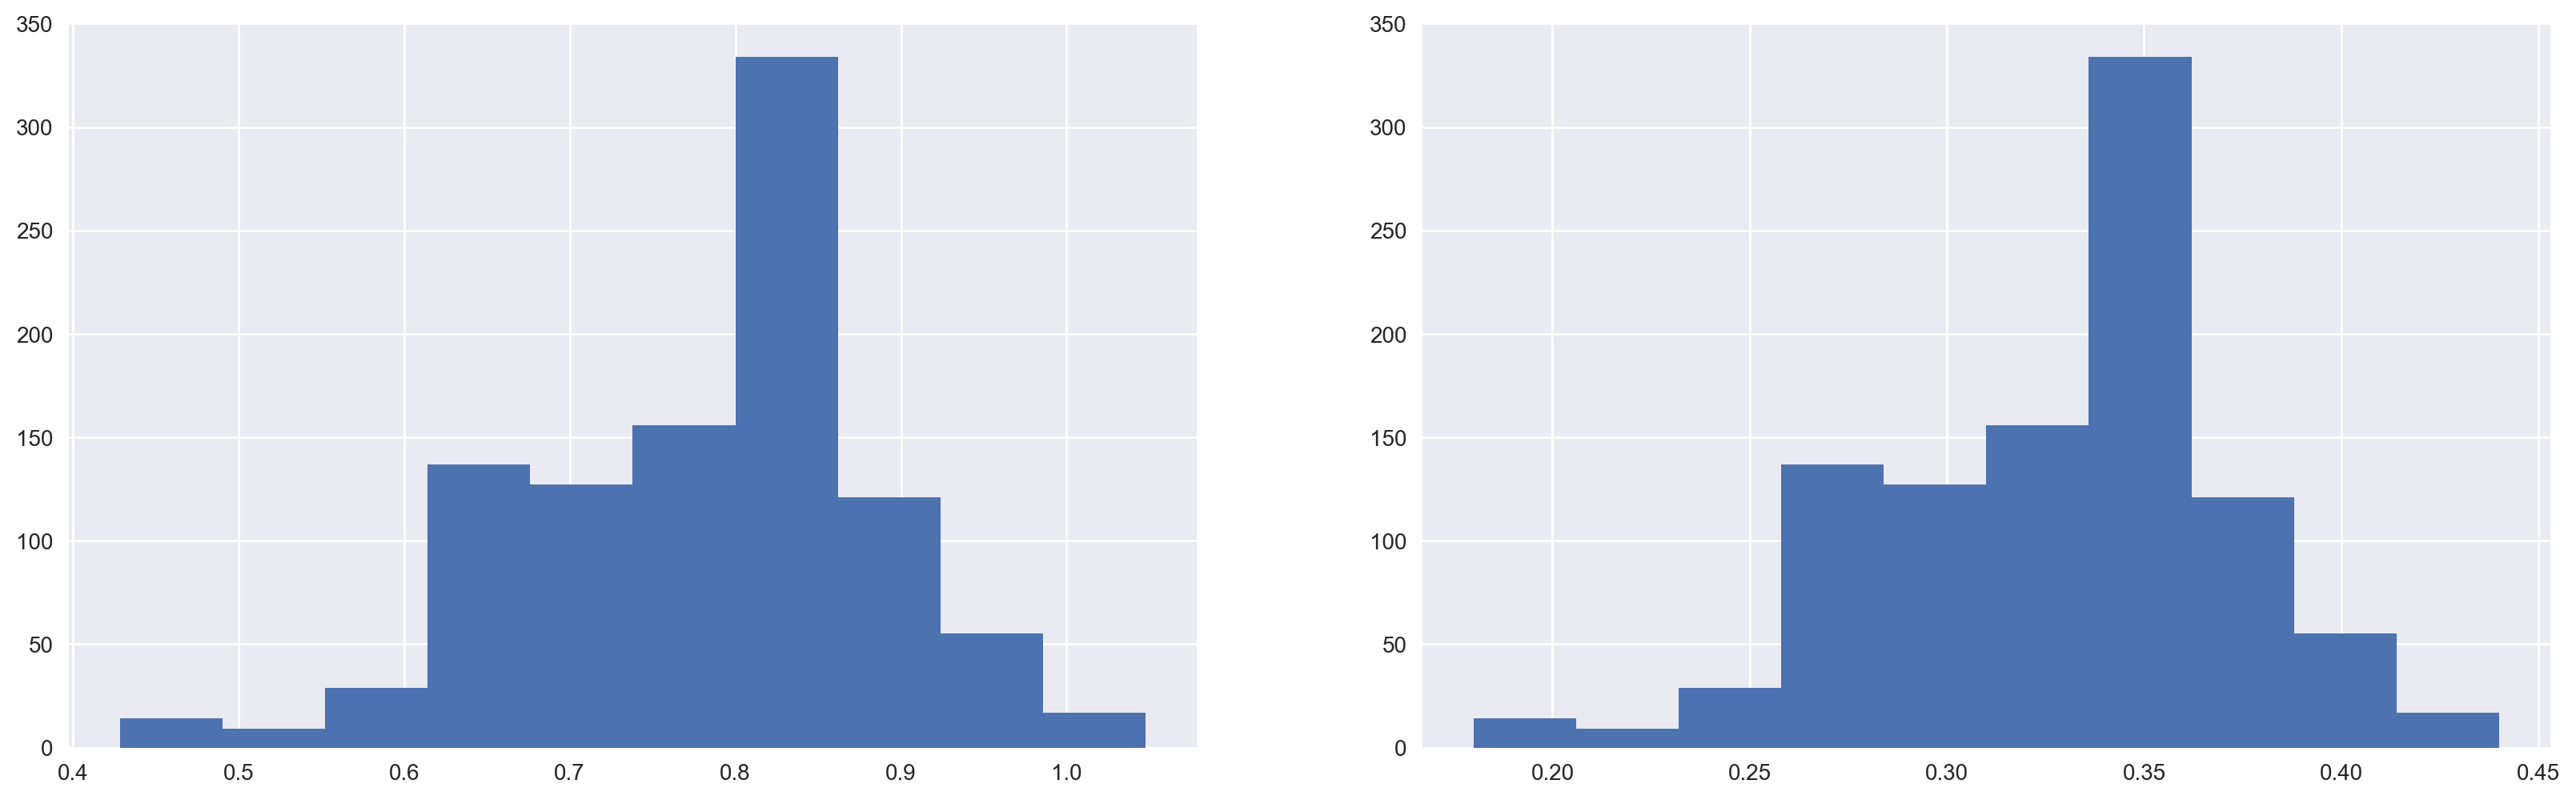

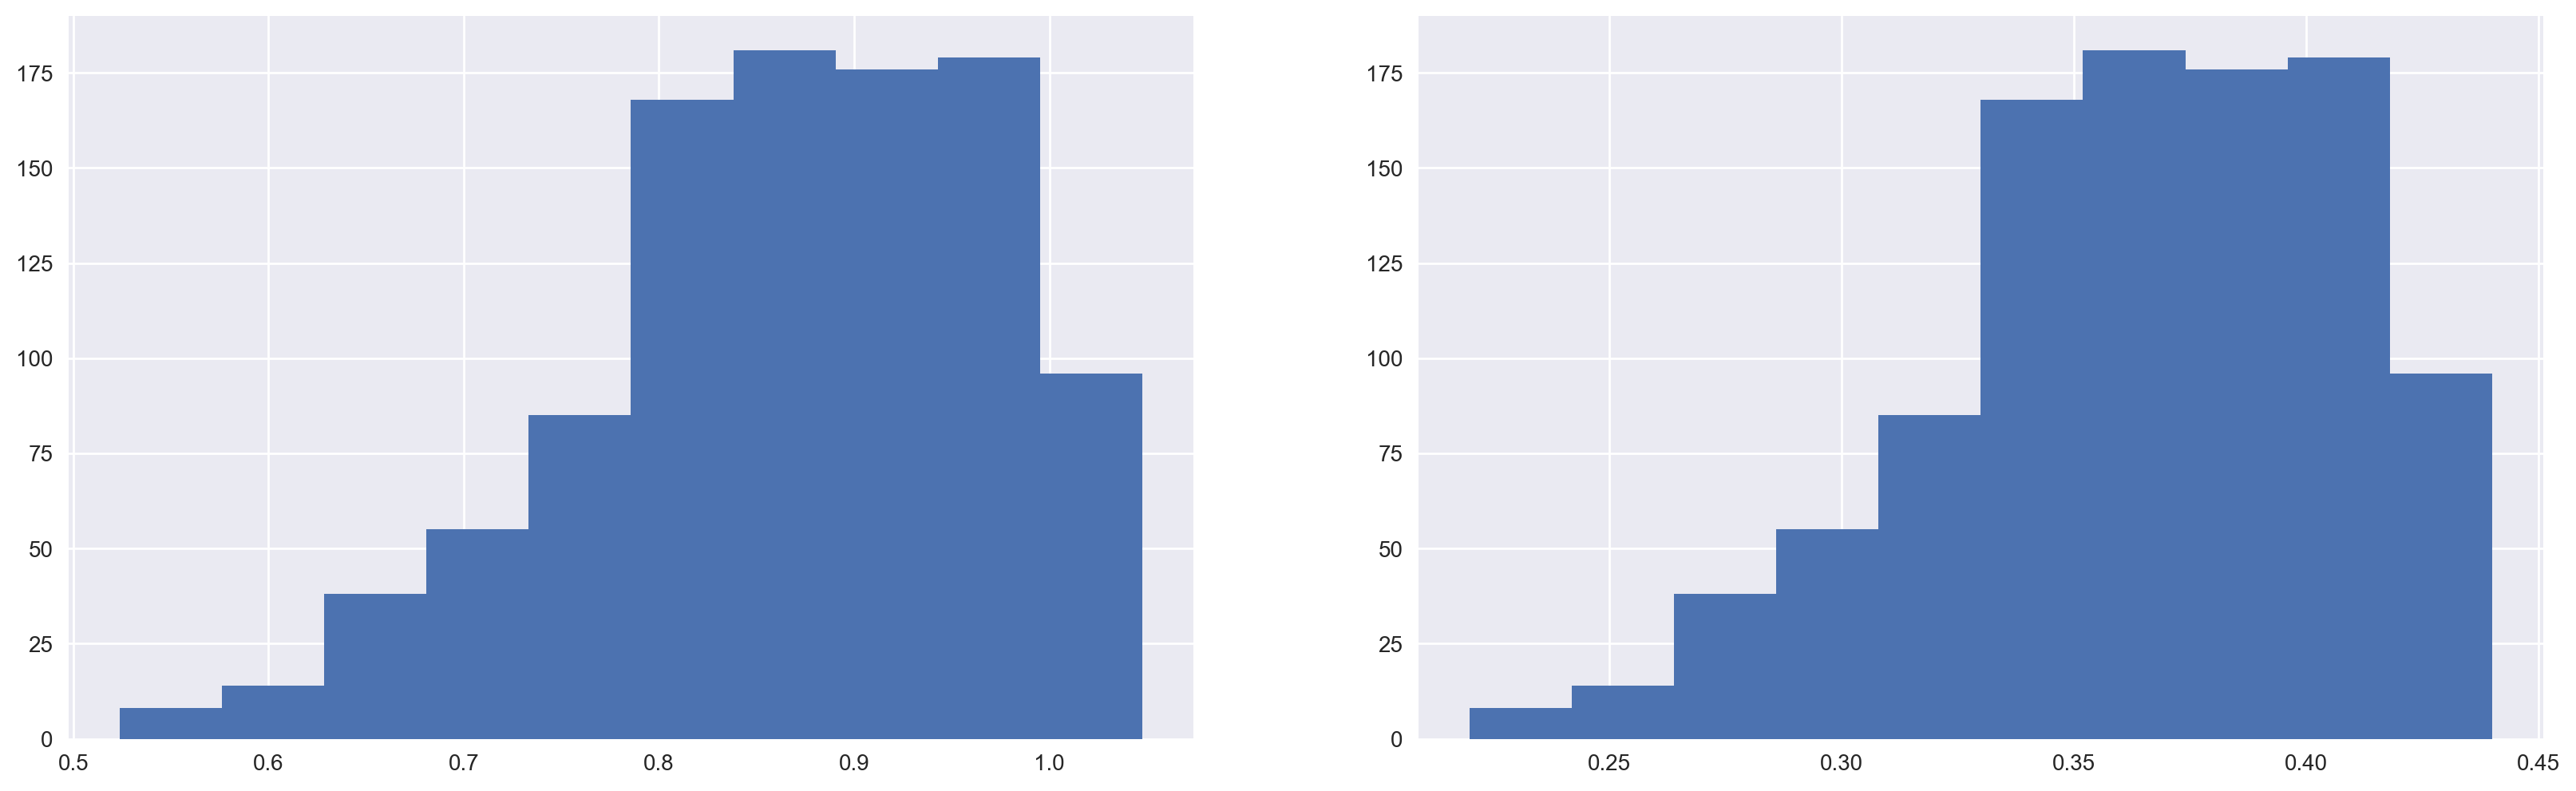

In [167]:
plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.hist(rclean_ratios)
plt.subplot(1,2,2)
plt.hist(rcleaning_rates)
plt.show()

plt.figure(figsize=(20,6),dpi=200)
plt.subplot(1,2,1)
plt.hist(oclean_ratios)
plt.subplot(1,2,2)
plt.hist(ocleaning_rates)
plt.show()

In [ ]:
def sim_diff_density(traffic_sim, density=density, n_loops=100, **kwargs):
    
    '''
    Run traffic simulation at different densities to analyze traffic behavior.
    For each loop in n_loops, the simulation is updated by 100 steps.
    
    Inputs:
        
    traffic_sim (class) The traffic simulation class to be used.
                
    density (arr) The range of traffic densities to test for.
        Default: np.arange(0,1.05,0.05)

    n_loops (int) The number of times to run the simulation.
        Default: 100
        
    **kwargs Any additional keywords for the traffic_sim class
        
    Outputs:
    
    avg_traffic_flows (lst) Traffic flows for each density (length: n_loops)
    
    mean_traffic_flows (lst) Mean traffic flows for each density (length: len(density))
    
    CI_traffic_flows (lst) 95% Confidence intervals of traffic flows for each density 
                            (length: len(density))
    
    '''
    avg_traffic_flows = []
    mean_traffic_flows = []
    CI_traffic_flows = []

    for d in density:

        temp = []

        for n in range(n_loops):
            #initialize the sim with a given density
            sim = traffic_sim(car_density=d, **kwargs)
            
            #update the sim 100 times
            for t in range(100):
                sim.step()

            #get the traffic flow for a given density
            avg_traffic_flows.append((d, sim.cumulative_traffic_flow / sim.time_step))
            temp.append(sim.cumulative_traffic_flow / sim.time_step)

        #mean traffic flow for a given density
        mean_traffic_flows.append(np.mean(temp))
        
        #95 CI of traffic flow for a given density
        CI_traffic_flows.append(np.percentile(temp,[2.5,97.5]))
        
    return avg_traffic_flows, mean_traffic_flows, CI_traffic_flows

In [ ]:
        elif self.strat == 'wall-following':
            #description
            top_bottom_sensor = {neighborhood['top'],neighborhood['top-right'],neighborhood['top-left'],
                                 neighborhood['bottom'],neighborhood['bottom-right'],neighborhood['bottom-left']}
            right_left_sensor = {neighborhood['top-right'],neighborhood['right'],neighborhood['bottom-right'],
                                neighborhood['top-left'],neighborhood['left'],neighborhood['bottom-left']}
            top_right_corner = {neighborhood['top'],neighborhood['top-right'],neighborhood['right']}
            top_left_corner = {neighborhood['top'],neighborhood['top-left'],neighborhood['left']}
            bottom_left_corner = {neighborhood['bottom'],neighborhood['bottom-left'],neighborhood['left']}
            bottom_right_corner = {neighborhood['bottom'],neighborhood['bottom-right'],neighborhood['right']}
            
            
            if self.found_wall == 'top-bottom' or top_bottom_sensor == (top_bottom_sensor & self.obstacle_loc):
                #move left or right
                pos = {neighborhood['left'], neighborhood['right']}
                if pos - self.obstacle_loc >= 1:
                    free_pos = pos - self.obstacle_loc
                    self.found_wall = 'top-bottom'

            elif self.found_wall == 'left-right' or right_left_sensor == (right_left_sensor & self.obstacle_loc):
                #move up or down
                pos = {neighborhood['top'], neighborhood['bottom']}
                if pos - self.obstacle_loc >= 1:
                    free_pos = pos - self.obstacle_loc
                    self.found_wall = 'left-right'
                    
            print(self.found_wall)

Think about number of timesteps and explain why you picked what you picked